Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 5.3 MB/s 
     |████████████████████████████████| 10.6 MB 11.1 MB/s 
     |████████████████████████████████| 829 kB 81.2 MB/s 
     |████████████████████████████████| 118 kB 74.6 MB/s 
     |████████████████████████████████| 234 kB 67.4 MB/s 
     |████████████████████████████████| 636 kB 83.5 MB/s 
     |████████████████████████████████| 1.3 MB 71.6 MB/s 
     |████████████████████████████████| 294 kB 67.4 MB/s 
     |████████████████████████████████| 142 kB 88.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 17
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'inception'
BATCH_SIZE = 128
NUM_EPOCHS = 100

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp017'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 01:25:42,696 - __main__ - INFO - Experiment no: 17
2021-07-21 01:25:42,699 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 01:25:42,701 - __main__ - INFO - SEED: 1
2021-07-21 01:25:42,702 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 01:25:42,716 - __main__ - DEBUG - Start loading csv files (0.007 seconds passed)
2021-07-21 01:25:43,654 - __main__ - DEBUG - Complete loading csv files (0.945 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 01:25:44,023 - __main__ - DEBUG - Start fold 1 (1.314 seconds passed)
2021-07-21 01:25:44,030 - __main__ - DEBUG - Start training model (1.321 seconds passed)
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
2021-07-21 01:29:32,219 - __main__ - DEBUG - Epoch 0/99
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, str

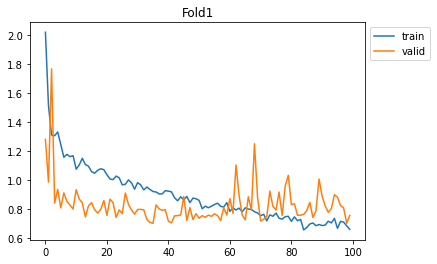

2021-07-21 02:22:53,576 - __main__ - DEBUG - Complete prediction for train fold (3430.867 seconds passed)
2021-07-21 02:22:56,893 - __main__ - DEBUG - Complete prediction for val fold (3434.184 seconds passed)
2021-07-21 02:28:18,244 - __main__ - DEBUG - Complete prediction for test fold (3755.535 seconds passed)
2021-07-21 02:28:18,263 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp017/cv_fold1_training.csv (3755.554 seconds passed)
2021-07-21 02:28:18,271 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp017/cv_fold1_validation.csv (3755.562 seconds passed)
2021-07-21 02:28:18,290 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp017/cv_fold1_test.csv (3755.581 seconds passed)
2021-07-21 02:28:18,593 - __main__ - DEBUG - Save model ../scripts/../experiments/exp017/cv_fold1_model.torch (3755.884 seconds passed)
2021-07-21 02:28:18,695 - __main__ - DEBUG - Complete fold 1 (3755.986 seconds passed)
2021-07-21 02:28:18,702

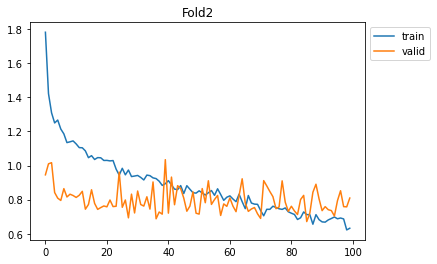

2021-07-21 03:21:41,888 - __main__ - DEBUG - Complete prediction for train fold (6959.179 seconds passed)
2021-07-21 03:21:45,139 - __main__ - DEBUG - Complete prediction for val fold (6962.430 seconds passed)
2021-07-21 03:22:01,877 - __main__ - DEBUG - Complete prediction for test fold (6979.168 seconds passed)
2021-07-21 03:22:01,896 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp017/cv_fold2_training.csv (6979.186 seconds passed)
2021-07-21 03:22:01,905 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp017/cv_fold2_validation.csv (6979.195 seconds passed)
2021-07-21 03:22:01,927 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp017/cv_fold2_test.csv (6979.218 seconds passed)
2021-07-21 03:22:02,274 - __main__ - DEBUG - Save model ../scripts/../experiments/exp017/cv_fold2_model.torch (6979.564 seconds passed)
2021-07-21 03:22:02,367 - __main__ - DEBUG - Complete fold 2 (6979.657 seconds passed)
2021-07-21 03:22:02,369

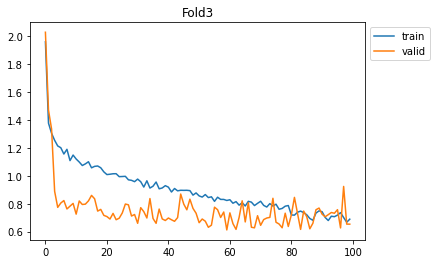

2021-07-21 04:15:19,525 - __main__ - DEBUG - Complete prediction for train fold (10176.816 seconds passed)
2021-07-21 04:15:22,829 - __main__ - DEBUG - Complete prediction for val fold (10180.120 seconds passed)
2021-07-21 04:15:39,446 - __main__ - DEBUG - Complete prediction for test fold (10196.737 seconds passed)
2021-07-21 04:15:39,464 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp017/cv_fold3_training.csv (10196.754 seconds passed)
2021-07-21 04:15:39,472 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp017/cv_fold3_validation.csv (10196.763 seconds passed)
2021-07-21 04:15:39,492 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp017/cv_fold3_test.csv (10196.782 seconds passed)
2021-07-21 04:15:39,811 - __main__ - DEBUG - Save model ../scripts/../experiments/exp017/cv_fold3_model.torch (10197.101 seconds passed)
2021-07-21 04:15:39,904 - __main__ - DEBUG - Complete fold 3 (10197.195 seconds passed)
2021-07-21 04:1

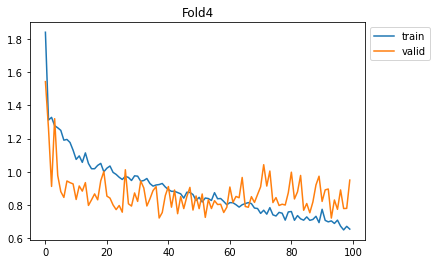

2021-07-21 05:08:59,789 - __main__ - DEBUG - Complete prediction for train fold (13397.080 seconds passed)
2021-07-21 05:09:03,122 - __main__ - DEBUG - Complete prediction for val fold (13400.412 seconds passed)
2021-07-21 05:09:19,766 - __main__ - DEBUG - Complete prediction for test fold (13417.057 seconds passed)
2021-07-21 05:09:19,784 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp017/cv_fold4_training.csv (13417.075 seconds passed)
2021-07-21 05:09:19,793 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp017/cv_fold4_validation.csv (13417.084 seconds passed)
2021-07-21 05:09:19,814 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp017/cv_fold4_test.csv (13417.104 seconds passed)
2021-07-21 05:09:20,124 - __main__ - DEBUG - Save model ../scripts/../experiments/exp017/cv_fold4_model.torch (13417.414 seconds passed)
2021-07-21 05:09:20,221 - __main__ - DEBUG - Complete fold 4 (13417.512 seconds passed)
2021-07-21 05:0

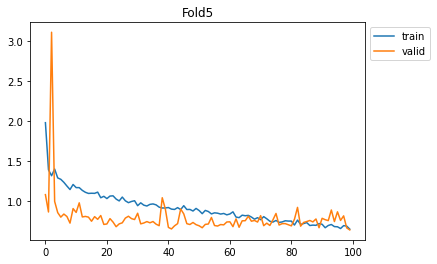

2021-07-21 06:02:38,386 - __main__ - DEBUG - Complete prediction for train fold (16615.677 seconds passed)
2021-07-21 06:02:41,794 - __main__ - DEBUG - Complete prediction for val fold (16619.085 seconds passed)
2021-07-21 06:02:58,710 - __main__ - DEBUG - Complete prediction for test fold (16636.001 seconds passed)
2021-07-21 06:02:58,730 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp017/cv_fold5_training.csv (16636.020 seconds passed)
2021-07-21 06:02:58,741 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp017/cv_fold5_validation.csv (16636.031 seconds passed)
2021-07-21 06:02:58,761 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp017/cv_fold5_test.csv (16636.052 seconds passed)
2021-07-21 06:02:59,082 - __main__ - DEBUG - Save model ../scripts/../experiments/exp017/cv_fold5_model.torch (16636.373 seconds passed)
2021-07-21 06:02:59,184 - __main__ - DEBUG - Complete fold 5 (16636.475 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 06:02:59,279 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 06:02:59,309 - __main__ - DEBUG - Loss: 0.6775043443976713
2021-07-21 06:02:59,310 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 06:02:59,320 - __main__ - DEBUG - Loss: 0.6510206692938431
2021-07-21 06:02:59,321 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 06:02:59,330 - __main__ - DEBUG - Loss: 0.6776218769780654
2021-07-21 06:02:59,331 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 06:02:59,341 - __main__ - DEBUG - Loss: 0.6083077768034455
2021-07-21 06:02:59,342 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 06:02:59,351 - __main__ - DEBUG - Loss: 0.584905042173164


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.03756,1
00309fb1ef05416f9c1f,2.02797,3
003a1562e97f79ba96dc,2.27938,3
004890880e8e7431147b,0.60676,2
00718c32602425f504c1,2.21025,3
...,...,...
ffa3259fff8e6f3818a1,2.18004,3
ffd4d361756587883e48,0.86243,1
ffd794b7b311b7b7fd92,1.85968,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 06:02:59,399 - __main__ - INFO - Training loss: 0.6938937498329698


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 06:02:59,421 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp017/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 06:02:59,445 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 06:02:59,455 - __main__ - DEBUG - Loss: 0.8358943274833642
2021-07-21 06:02:59,456 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 06:02:59,464 - __main__ - DEBUG - Loss: 0.8189287274946238
2021-07-21 06:02:59,465 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 06:02:59,473 - __main__ - DEBUG - Loss: 0.7814440627419184
2021-07-21 06:02:59,474 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 06:02:59,482 - __main__ - DEBUG - Loss: 0.8453591096901616
2021-07-21 06:02:59,483 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 06:02:59,491 - __main__ - DEBUG - Loss: 0.796779024212425


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.34768,1
00309fb1ef05416f9c1f,0.53949,3
003a1562e97f79ba96dc,0.48142,3
004890880e8e7431147b,0.14268,2
00718c32602425f504c1,0.56705,3
...,...,...
ffa3259fff8e6f3818a1,0.55254,3
ffd4d361756587883e48,0.21044,1
ffd794b7b311b7b7fd92,0.44777,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 06:02:59,531 - __main__ - INFO - Validatino loss: 1.6876493560026136


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 06:02:59,553 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp017/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 06:02:59,565 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp017/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.18801
000bd5e82eb22f199f44,2.30522
0015f44de1854f617516,1.91150
00388a678879ba1efa27,2.26930
005e1e7c6496902d23f3,0.61228
...,...
ffbe65ad399b632dcbd0,2.02819
ffd7b2d646c0320c311a,1.00347
ffdb93ede17d4501e530,1.45275


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.18801
1,2.30522
2,1.91150
3,2.26930
4,0.61228
...,...
5914,2.02819
5915,1.00347
5916,1.45275
5917,1.77259


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 06:02:59,682 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp017/017_submission.csv


2021-07-21 06:02:59,808 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp017/prediction.png


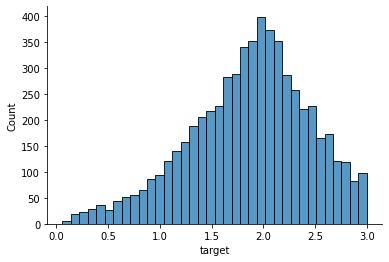

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 06:02:59,967 - __main__ - DEBUG - Complete (16637.258 seconds passed)
